<a href="https://colab.research.google.com/github/GKD-stack/DSC180A-Methodology-1/blob/main/DSC180A_Week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!! pip install pandas_plink
from pandas_plink import read_plink
import pandas_plink as pdplink
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Convert Tiffany’s 23andme data to VCF and plink files

Reference File Link: https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/technical/reference/

1. Text to BCF
```
bcftools convert --tsv2vcf Tiffany_data.txt.gz -f ref2.fa -s Tiffany -Ob -o Tiffany.bcf
```
2. BCF to VCF
```
bcftools view Tiffany.bcf -Ov -o Tiffany.vcf
```

3. VCF to bim, bed, and fam
```
plink --vcf Tiffany.vcf --make-bed --out Tiffany
```






# Part 2: Pruning and Thresholding Height

Download genome-wide summary statistics for a trait of your choosing (height is a great option) from my Github page, perform pruning and thresholding using a fixed threshold (p = 10 x 10^-4) because we cannot optimize this without the individual level data like we did for 1000 Genomes data.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/height.sumstats', sep='\t')
df

,SNP,A1,A2,N,CHISQ,Z
0,rs4075116,C,T,125107.0,3.760401,1.939175
1,rs3766192,C,T,127307.0,2.689682,1.640025
2,rs9442372,A,G,129083.0,2.254808,1.501602
3,rs3737728,A,G,127329.0,2.257134,1.502376
4,rs9442398,A,G,127348.0,2.870444,1.694238
...,...,...,...,...,...,...
1025710,rs4876928,C,T,96557.0,0.676484,0.822487
1025711,rs2606356,C,T,96458.0,0.365805,0.604818
1025712,rs2606357,T,C,89821.0,0.356065,0.596712
1025713,rs2739260,A,G,93075.0,0.299972,0.547697


In [ ]:
from scipy.stats import chi2
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/height.sumstats', sep='\t')

#make the p value column
df['p-value'] = df['CHISQ'].apply(lambda x: chi2.sf(x, df=1))
p_threshold = 1e-4
# threshold and prune
filtered_df = df[df['p-value'] <= p_threshold]
# Save file
filtered_df.to_csv('filtered_summary_stats.csv', sep='\t', index=False)

# 3. Merge All Data With Prof Data

Combine all the chromosome files together

```
plink --bfile LDREF/1000G.EUR.1 --merge-list merge_list.txt --make-bed --out 1000G_combined
```
Merge with Prof Data
```
plink --bfile 1000G_combined --bmerge Tiffany.bed Tiffany.bim Tiffany.fam --make-bed --out combined_with_Tiffany
```
Got an error message in plink for that there are mismatching SNPs, so I exclude them to do basically a inner merge in the next step

Filter Big file to not include mismatching SNPs
```
plink --bfile 1000G_combined --exclude combined_with_Tiffany-merge.missnp --make-bed --out new_merge
```
Merge with Prof Data Again
```
plink --bfile new_merge --bmerge Tiffany.bed Tiffany.bim Tiffany.fam --make-bed --out final_combined
```






Clean GWAS Height Data

In [ ]:
# Read in the GWAS summary statistics
gwas_summary = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Height.gwas.txt', sep='\t')
# Select the necessary columns and rename them to fit PLINK's expectations
prs_data = gwas_summary[['SNP', 'A1', 'OR']].copy()
prs_data.columns = ['SNP', 'ALLELE', 'BETA']

In [ ]:
# Save the reformatted data
prs_data.to_csv('/content/drive/My Drive/Colab Notebooks/Height.formatted.gwas.txt', sep=' ', index=False)

PRS for Height

```
plink --bfile final_combined --score Height.formatted.gwas.txt 1 2 3 sum --out prs_for_height
```



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Read in the PRS profile data
prs_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/prs_for_height.profile', delim_whitespace=True)
prs_data.head()

,FID,IID,PHENO,CNT,CNT2,SCORESUM
0,HG00096,HG00096,-9,239370,54740,71301.3
1,HG00097,HG00097,-9,239370,55195,71774.1
2,HG00099,HG00099,-9,239370,54394,70961.5
3,HG00101,HG00101,-9,239370,54474,71048.7
4,HG00102,HG00102,-9,239370,54763,71334.4


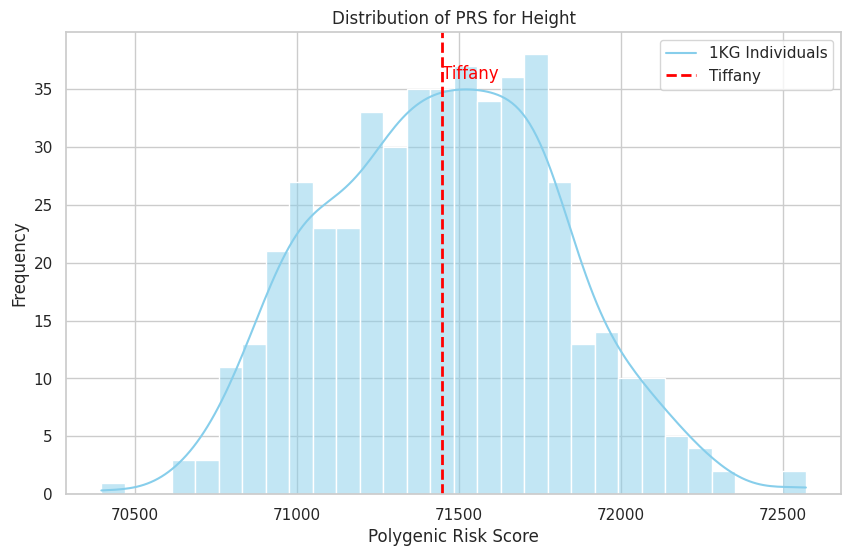

In [ ]:
# plot the distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(prs_data['SCORESUM'], kde=True, color="skyblue", bins=30)
plt.title('Distribution of PRS for Height')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency')

tiffany_prs = prs_data[prs_data['IID'] == 'Tiffany']['SCORESUM'].iloc[0]
plt.axvline(tiffany_prs, color='red', linestyle='dashed', linewidth=2)
plt.text(tiffany_prs, plt.ylim()[1]*0.9, 'Tiffany', color = 'red')

# Show
plt.legend(['1KG Individuals', 'Tiffany'])
plt.show()

In [ ]:
from scipy import stats
# Assuming 'prs_data' is a DataFrame that includes a 'SCORE' column with PRS values
tiffany_prs = prs_data[prs_data['IID'] == 'Tiffany']['SCORESUM'].iloc[0]
percentile = stats.percentileofscore(prs_data['SCORESUM'], tiffany_prs)
percentile

49.38775510204082